In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/ee417_project/masati/"

train_path = data_path + "train"
train_coco = "/content/drive/MyDrive/ee417_project/masati/annotations/instances_train.json"
test_path = data_path + "test"
test_coco = "/content/drive/MyDrive/ee417_project/masati/annotations/instances_test.json"
val_path = data_path + "valid"
val_coco = "/content/drive/MyDrive/ee417_project/masati/annotations/instances_val.json"


In [ ]:


# 3️⃣ COCO Dataset sınıfı
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import torch

class CustomCocoDataset(CocoDetection):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for obj in target:
            xmin, ymin, width, height = obj['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(obj['category_id'])
            areas.append(obj['area'])
            iscrowd.append(obj.get('iscrowd', 0))

        target_dict = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'area': torch.tensor(areas, dtype=torch.float32),
            'iscrowd': torch.tensor(iscrowd, dtype=torch.uint8)
        }

        return F.to_tensor(img), target_dict

# 4️⃣ Dataset ve Dataloader'ları oluştur
from torch.utils.data import DataLoader

train_dataset = CustomCocoDataset(train_path, train_coco)
valid_dataset = CustomCocoDataset(val_path, val_coco)
test_dataset = CustomCocoDataset(test_path, test_coco)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Dataset hazır: Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")


loading annotations into memory...
Done (t=4.41s)
creating index...
index created!
loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!
Dataset hazır: Train: 3617, Valid: 452, Test: 453


In [ ]:
class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, valid_indices):
        self.dataset = dataset
        self.valid_indices = valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        return self.dataset[real_idx]


In [ ]:
import json

with open(train_coco, 'r') as f:
    annotations = json.load(f)

# 1️⃣ BBox olan image_id'leri topla
image_ids_with_boxes = set(ann['image_id'] for ann in annotations['annotations'])
print(f"🔍 {len(image_ids_with_boxes)} adet BB içeren img var.")

# 2️⃣ image_id -> dataset index map'i oluştur
image_id_to_index = {img_info['id']: idx for idx, img_info in enumerate(annotations['images'])}

# 3️⃣ BBox OLMAYAN (background-only) image index'lerini al
background_only_indices = [image_id_to_index[img_info['id']]
                           for img_info in annotations['images']
                           if img_info['id'] not in image_ids_with_boxes]
print(f"✅ {len(background_only_indices)} adet background-only index bulundu.")


🔍 1888 adet BB içeren img var.
✅ 1729 adet background-only index bulundu.


In [ ]:
filtered_train_dataset = FilteredDataset(train_dataset, background_only_indices)
filtered_train_loader = DataLoader(
    filtered_train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from tqdm import tqdm  # 🟦

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),   #
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 🟦 Model ve optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

# 🟦 Best weight tracking
best_loss = float('inf')
best_model_weights = None
save_path = "/content/drive/MyDrive/EE417/autoencoder/autoencoder_best_weights.pth"

# 🟦 Training loop
num_epochs = 30

for epoch in range(num_epochs):
    autoencoder.train()
    epoch_loss = 0.0

    pbar = tqdm(filtered_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  # TQDM progress bar

    for batch in pbar:
        # Extract the images from the batch tuple and stack them into a tensor
        images = torch.stack(batch[0]).to(device)

        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix(loss=loss.item())  # 🟦 Güncel loss değeri

    avg_loss = epoch_loss / len(filtered_train_loader)
    print(f"✅ Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.6f}")

    # 🟦 Save best weights
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_weights = autoencoder.state_dict()
        torch.save(best_model_weights, save_path)
        print(f"💾 Yeni best model kaydedildi! Loss: {best_loss:.6f}")

print("🏁 Eğitim tamamlandı!")
print(f"🔐 Best model kaydedildi: {save_path}")

Epoch 1/30: 100%|██████████| 217/217 [00:23<00:00,  9.36it/s, loss=0.000726]


✅ Epoch 1/30 - Avg Loss: 0.024437
💾 Yeni best model kaydedildi! Loss: 0.024437


Epoch 2/30: 100%|██████████| 217/217 [00:23<00:00,  9.40it/s, loss=0.0126]


✅ Epoch 2/30 - Avg Loss: 0.014233
💾 Yeni best model kaydedildi! Loss: 0.014233


Epoch 3/30: 100%|██████████| 217/217 [00:22<00:00,  9.46it/s, loss=0.0158]


✅ Epoch 3/30 - Avg Loss: 0.012284
💾 Yeni best model kaydedildi! Loss: 0.012284


Epoch 4/30: 100%|██████████| 217/217 [00:22<00:00,  9.44it/s, loss=0.0342]


✅ Epoch 4/30 - Avg Loss: 0.012268
💾 Yeni best model kaydedildi! Loss: 0.012268


Epoch 5/30: 100%|██████████| 217/217 [00:22<00:00,  9.45it/s, loss=0.0072]


✅ Epoch 5/30 - Avg Loss: 0.011738
💾 Yeni best model kaydedildi! Loss: 0.011738


Epoch 6/30: 100%|██████████| 217/217 [00:22<00:00,  9.45it/s, loss=0.00436]


✅ Epoch 6/30 - Avg Loss: 0.011577
💾 Yeni best model kaydedildi! Loss: 0.011577


Epoch 7/30: 100%|██████████| 217/217 [00:23<00:00,  9.31it/s, loss=0.00173]


✅ Epoch 7/30 - Avg Loss: 0.011544
💾 Yeni best model kaydedildi! Loss: 0.011544


Epoch 8/30: 100%|██████████| 217/217 [00:23<00:00,  9.13it/s, loss=0.0212]


✅ Epoch 8/30 - Avg Loss: 0.011626


Epoch 9/30: 100%|██████████| 217/217 [00:23<00:00,  9.29it/s, loss=0.00647]


✅ Epoch 9/30 - Avg Loss: 0.011537
💾 Yeni best model kaydedildi! Loss: 0.011537


Epoch 10/30: 100%|██████████| 217/217 [00:23<00:00,  9.21it/s, loss=0.0112]


✅ Epoch 10/30 - Avg Loss: 0.011509
💾 Yeni best model kaydedildi! Loss: 0.011509


Epoch 11/30: 100%|██████████| 217/217 [00:23<00:00,  9.36it/s, loss=0.00403]


✅ Epoch 11/30 - Avg Loss: 0.011342
💾 Yeni best model kaydedildi! Loss: 0.011342


Epoch 12/30: 100%|██████████| 217/217 [00:23<00:00,  9.39it/s, loss=0.00126]


✅ Epoch 12/30 - Avg Loss: 0.011212
💾 Yeni best model kaydedildi! Loss: 0.011212


Epoch 13/30: 100%|██████████| 217/217 [00:23<00:00,  9.32it/s, loss=0.00834]


✅ Epoch 13/30 - Avg Loss: 0.011108
💾 Yeni best model kaydedildi! Loss: 0.011108


Epoch 14/30: 100%|██████████| 217/217 [00:23<00:00,  9.43it/s, loss=0.00287]


✅ Epoch 14/30 - Avg Loss: 0.010884
💾 Yeni best model kaydedildi! Loss: 0.010884


Epoch 15/30: 100%|██████████| 217/217 [00:23<00:00,  9.42it/s, loss=0.00643]


✅ Epoch 15/30 - Avg Loss: 0.010878
💾 Yeni best model kaydedildi! Loss: 0.010878


Epoch 16/30: 100%|██████████| 217/217 [00:23<00:00,  9.33it/s, loss=0.00215]


✅ Epoch 16/30 - Avg Loss: 0.010687
💾 Yeni best model kaydedildi! Loss: 0.010687


Epoch 17/30: 100%|██████████| 217/217 [00:23<00:00,  9.40it/s, loss=0.00747]


✅ Epoch 17/30 - Avg Loss: 0.010529
💾 Yeni best model kaydedildi! Loss: 0.010529


Epoch 18/30: 100%|██████████| 217/217 [00:23<00:00,  9.35it/s, loss=0.00266]


✅ Epoch 18/30 - Avg Loss: 0.010390
💾 Yeni best model kaydedildi! Loss: 0.010390


Epoch 19/30: 100%|██████████| 217/217 [00:23<00:00,  9.40it/s, loss=0.00248]


✅ Epoch 19/30 - Avg Loss: 0.010414


Epoch 20/30: 100%|██████████| 217/217 [00:23<00:00,  9.33it/s, loss=0.0213]


✅ Epoch 20/30 - Avg Loss: 0.010303
💾 Yeni best model kaydedildi! Loss: 0.010303


Epoch 21/30: 100%|██████████| 217/217 [00:23<00:00,  9.14it/s, loss=0.0141]


✅ Epoch 21/30 - Avg Loss: 0.010305


Epoch 22/30: 100%|██████████| 217/217 [00:23<00:00,  9.23it/s, loss=0.00592]


✅ Epoch 22/30 - Avg Loss: 0.010182
💾 Yeni best model kaydedildi! Loss: 0.010182


Epoch 23/30: 100%|██████████| 217/217 [00:23<00:00,  9.26it/s, loss=0.0131]


✅ Epoch 23/30 - Avg Loss: 0.010200


Epoch 24/30: 100%|██████████| 217/217 [00:23<00:00,  9.22it/s, loss=0.00968]


✅ Epoch 24/30 - Avg Loss: 0.009340
💾 Yeni best model kaydedildi! Loss: 0.009340


Epoch 25/30: 100%|██████████| 217/217 [00:23<00:00,  9.35it/s, loss=0.00639]


✅ Epoch 25/30 - Avg Loss: 0.008992
💾 Yeni best model kaydedildi! Loss: 0.008992


Epoch 26/30: 100%|██████████| 217/217 [00:23<00:00,  9.30it/s, loss=0.00527]


✅ Epoch 26/30 - Avg Loss: 0.008777
💾 Yeni best model kaydedildi! Loss: 0.008777


Epoch 27/30: 100%|██████████| 217/217 [00:23<00:00,  9.34it/s, loss=0.00535]


✅ Epoch 27/30 - Avg Loss: 0.008662
💾 Yeni best model kaydedildi! Loss: 0.008662


Epoch 28/30: 100%|██████████| 217/217 [00:23<00:00,  9.30it/s, loss=0.00327]


✅ Epoch 28/30 - Avg Loss: 0.008686


Epoch 29/30: 100%|██████████| 217/217 [00:23<00:00,  9.38it/s, loss=0.00686]


✅ Epoch 29/30 - Avg Loss: 0.008609
💾 Yeni best model kaydedildi! Loss: 0.008609


Epoch 30/30: 100%|██████████| 217/217 [00:23<00:00,  9.43it/s, loss=0.00668]

✅ Epoch 30/30 - Avg Loss: 0.008630
🏁 Eğitim tamamlandı!
🔐 Best model kaydedildi: /content/drive/MyDrive/EE417/autoencoder/autoencoder_best_weights.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from tqdm import tqdm  # 🟦
save_path = "/content/drive/MyDrive/EE417/autoencoder/autoencoder_best_weights.pth"
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),   #
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
loaded_autoencoder = ConvAutoencoder().to(device)

# ✅ Ağırlıkları yükle
loaded_autoencoder.load_state_dict(torch.load(save_path))

# ✅ Eval moduna al
loaded_autoencoder.eval()

print("🎉 Best autoencoder ağırlıkları başarıyla yüklendi ve inference için hazır!")


🎉 Best autoencoder ağırlıkları başarıyla yüklendi ve inference için hazır!


🔎 Reconstruction MSE: 0.003604


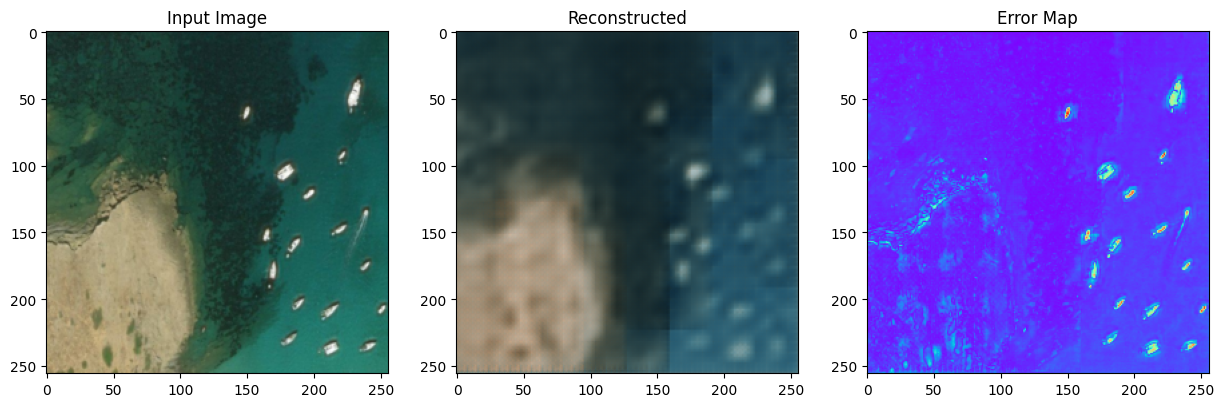

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

# 🟦 Modeli ve cihazı yükle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_autoencoder.eval()

# 🟧 Görsel yükleme ve transform (örnek)
img_path = "/content/drive/MyDrive/ee417_project/masati/test/y0051.png"  #
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
input_img = transform(img).unsqueeze(0).to(device)  # [1, 3, 256, 256]

# 🟦 Forward pass
with torch.no_grad():
    reconstructed = loaded_autoencoder(input_img)

# 🟩 Reconstruction Error hesapla
error_map = torch.abs(input_img - reconstructed).squeeze(0).cpu()
mse_error = torch.mean((input_img - reconstructed) ** 2).item()
print(f"🔎 Reconstruction MSE: {mse_error:.6f}")



# Görselleştirme
input_img_disp = input_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed_disp = reconstructed.squeeze(0).permute(1, 2, 0).cpu().numpy()
error_map_disp = np.mean(error_map.permute(1,2,0).numpy(), axis=2)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(input_img_disp)
plt.title("Input Image")

plt.subplot(1,3,2)
plt.imshow(reconstructed_disp)
plt.title("Reconstructed")

plt.subplot(1,3,3)
plt.imshow(error_map_disp, cmap='rainbow')
plt.title("Error Map")

plt.show()


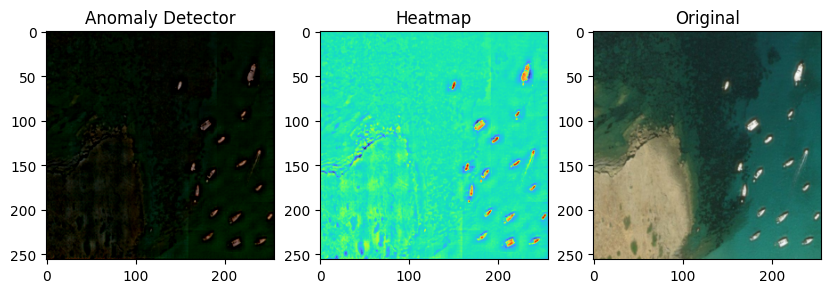

In [ ]:
import cv2
import numpy as np

input_img_disp = input_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed_disp = reconstructed.squeeze(0).permute(1, 2, 0).cpu().numpy()
error_map_disp = np.mean(error_map.permute(1,2,0).numpy(), axis=2)


image1 = input_img_disp
image2 = reconstructed_disp
image3 = np.zeros_like(image1)

for i in range(image1.shape[0]):
  for j in range(image1.shape[1]):
    for k in range(3):
      anomaly = ((image1[i][j][k] - image2[i][j][k]))
      image3[i][j][k] = anomaly

ls = list()



for i in range(image3.shape[0]):
    for j in range(image3.shape[1]):

        temp = image3[i][j].mean()
        ls.append(temp)

ls = np.array(ls)
type(ls)

ls.shape = (256,256)





plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image3)
plt.title("Anomaly Detector")
plt.subplot(1,3,2)
plt.imshow(ls,cmap="turbo")
plt.title("Heatmap")
plt.subplot(1,3,3)
plt.imshow(image1)
plt.title("Original")
plt.show()